In [1]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf
from tensorflow.keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping 
from sklearn.model_selection import train_test_split 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.applications import resnet50
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
import keras
import warnings
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import os

from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

warnings.filterwarnings('ignore')

In [2]:
def data_prep(MildDementia, ModerateDementia, VerymildDementia, NonDemented):

    MildDementia= ["imagesoasis/Data/Mild Dementia" + '/' +  MildDementia for MildDementia in MildDementia]
    ModerateDementia= ["imagesoasis/Data/Moderate Dementia"  + '/' +  ModerateDementia for ModerateDementia in ModerateDementia]
    VerymildDementia= ["imagesoasis/Data/Very mild Dementia"  + '/' +  VerymildDementia for VerymildDementia in VerymildDementia]
    NonDemented= ["imagesoasis/Data/Non Demented"  + '/' +  NonDemented for NonDemented in NonDemented]

    labels = len(MildDementia)*['MildDementia'] + len(ModerateDementia)*['ModerateDementia'] + len(VerymildDementia)*['VerymildDementia'] + len(NonDemented)*['NonDemented']
    data = MildDementia + ModerateDementia + VerymildDementia + NonDemented

    return pd.DataFrame({'Image_Path': data , 'Labels': labels})

In [5]:
df = data_prep(os.listdir('imagesoasis/Data/Mild Dementia'), os.listdir('imagesoasis/Data/Moderate Dementia'),
               os.listdir('imagesoasis/Data/Very mild Dementia'), os.listdir('imagesoasis/Data/Non Demented'))

In [7]:
df = df.sample(frac=1).reset_index(drop=True)

In [9]:
df.sample(10)

,Image_Path,Labels
59792,imagesoasis/Data/Very mild Dementia/OAS1_0022_...,VerymildDementia
28066,imagesoasis/Data/Non Demented/OAS1_0072_MR1_mp...,NonDemented
59198,imagesoasis/Data/Non Demented/OAS1_0126_MR1_mp...,NonDemented
52570,imagesoasis/Data/Non Demented/OAS1_0236_MR1_mp...,NonDemented
25294,imagesoasis/Data/Non Demented/OAS1_0180_MR1_mp...,NonDemented
20930,imagesoasis/Data/Non Demented/OAS1_0202_MR1_mp...,NonDemented
72913,imagesoasis/Data/Non Demented/OAS1_0129_MR1_mp...,NonDemented
6702,imagesoasis/Data/Very mild Dementia/OAS1_0290_...,VerymildDementia
58726,imagesoasis/Data/Non Demented/OAS1_0309_MR1_mp...,NonDemented
28669,imagesoasis/Data/Mild Dementia/OAS1_0052_MR1_m...,MildDementia


In [11]:
def plot_images(class_label, df, num_images=5):

    class_df = df[df['Labels'] == class_label].head(num_images)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    axes = axes.flatten()

    for i, (img_path) in enumerate(class_df['Image_Path']):
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        axes[i].imshow(img_rgb)
        axes[i].axis('off')
        axes[i].set_title(f'{class_label} - Image {i+1}')

    plt.tight_layout()
    plt.show()

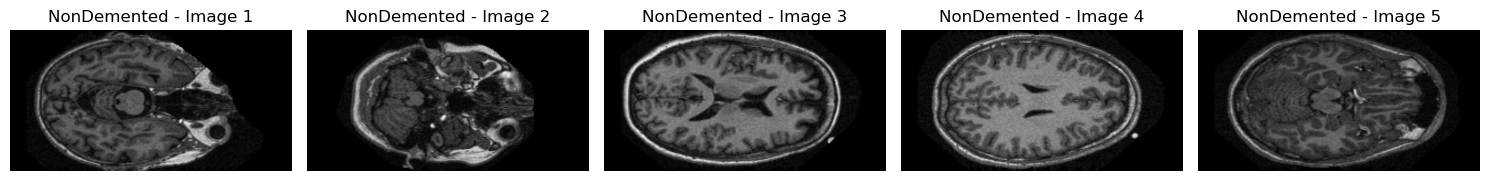

In [15]:
plot_images('NonDemented', df)

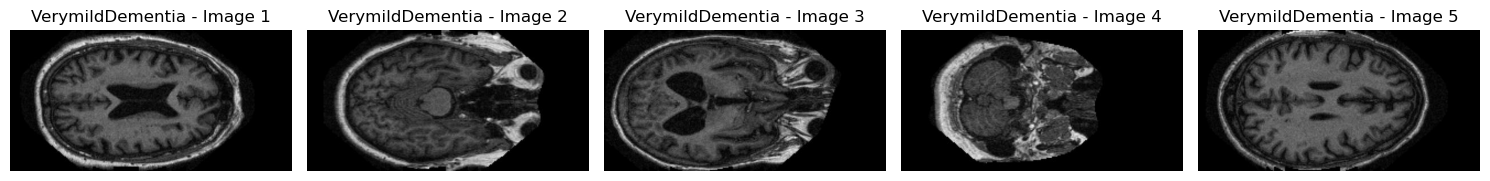

In [16]:
plot_images('VerymildDementia', df)

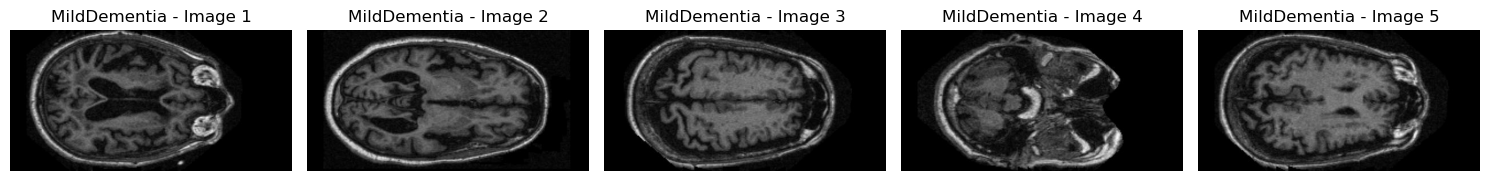

In [19]:
plot_images('MildDementia', df)

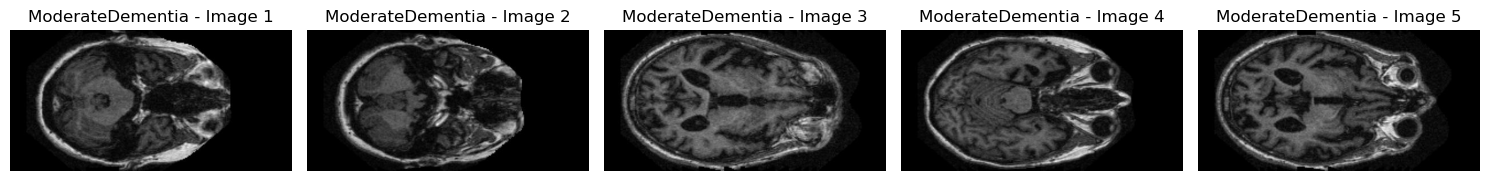

In [21]:
plot_images('ModerateDementia', df)

In [23]:
df.Labels.value_counts()

Labels
NonDemented         67222
VerymildDementia    13725
MildDementia         5002
ModerateDementia      488
Name: count, dtype: int64

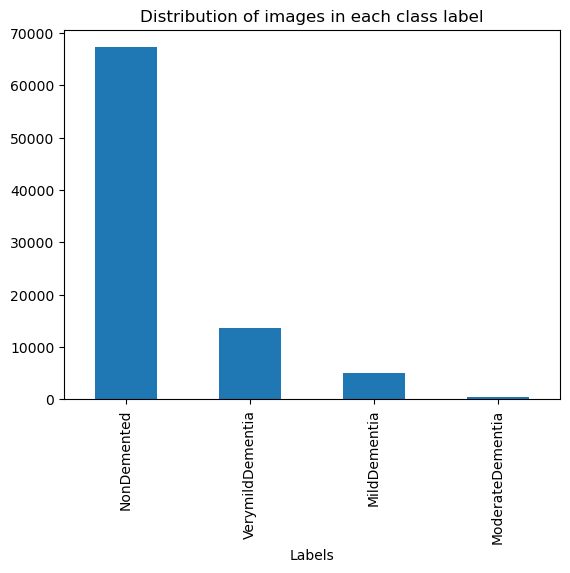

In [25]:
df['Labels'].value_counts().plot(kind = 'bar')
plt.title('Distribution of images in each class label')
plt.show()

Data is imbalanced hence reducing the data size by using the sample images from majority classes

In [28]:
df = df.groupby('Labels').apply(lambda x: x.sample(n=5000, random_state=42) if x['Labels'].iloc[0] in ['NonDemented', 'VerymildDementia', 'MildDementia'] else x)
df = df.reset_index(drop=True)

In [30]:
df.Labels.value_counts()

Labels
MildDementia        5000
NonDemented         5000
VerymildDementia    5000
ModerateDementia     488
Name: count, dtype: int64

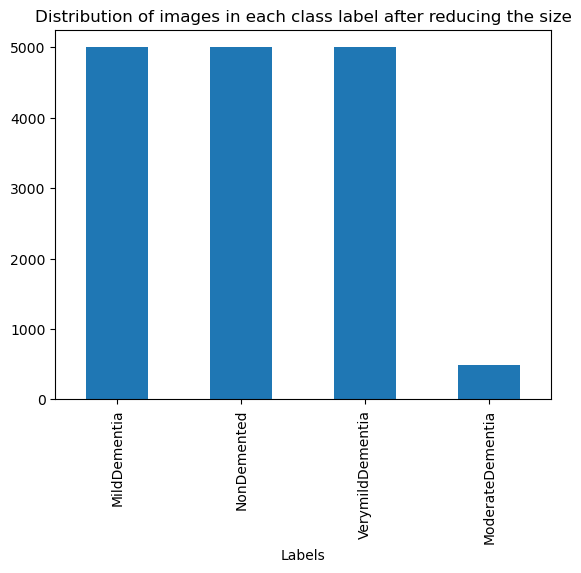

In [32]:
df['Labels'].value_counts().plot(kind = 'bar')
plt.title('Distribution of images in each class label after reducing the size')
plt.show()

In [34]:
train, test = train_test_split(df, test_size = .30)

In [36]:
datagen = ImageDataGenerator(
    rescale=1./255,                    # Rescale pixel values to [0, 1]
    rotation_range=40,                 # Random rotations between 0 and 40 degrees
    width_shift_range=0.2,             # Randomly shift images horizontally
    height_shift_range=0.2,            # Randomly shift images vertically
    shear_range=0.2,                   # Shear transformations
    zoom_range=0.2,                    # Random zoom
    horizontal_flip=True,              # Random horizontal flip
    fill_mode='nearest'                # Fill in pixels after transformations
)

In [38]:
train_generator = datagen.flow_from_dataframe(
    dataframe=train,
    directory=None,                     # File paths are in the dataframe
    x_col='Image_Path',                 # Column with image file paths
    y_col='Labels',                     # Column with labels
    target_size=(224, 224),             # Resize images to 224x224 (or your desired size)
    batch_size=32,                      # Number of images to process in each batch
    class_mode='categorical',           # Classification task (one-hot encoding)
    shuffle=True                        # Shuffle the data
)

Found 10841 validated image filenames belonging to 4 classes.


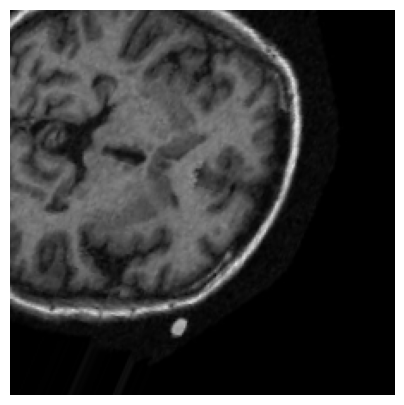

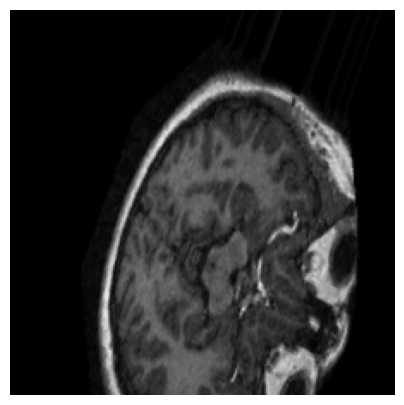

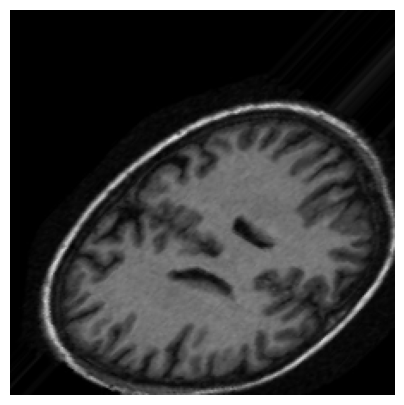

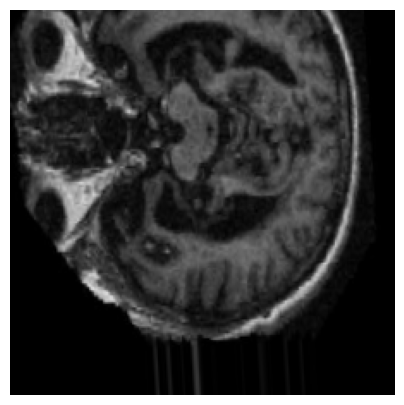

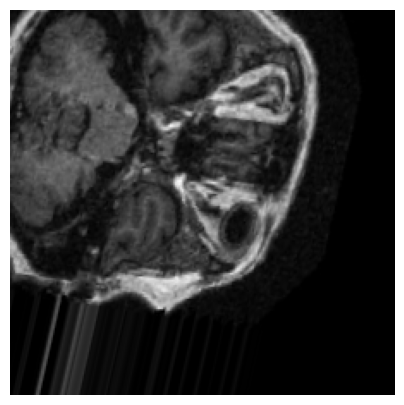

In [40]:
def augmented_images(generator, num_images=5):

    for i in range(num_images):
        img, label = next(generator)
        plt.figure(figsize=(5, 5))
        plt.imshow(img[0])
        plt.axis('off')
        plt.show()

augmented_images(train_generator, num_images=5)

In [41]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [44]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test,
    directory=None,                      # File paths are in the dataframe
    x_col='Image_Path',                   # Column with image file paths
    y_col='Labels',                       # Column with labels
    target_size=(224, 224),               # Resize images to 224x224 (or your desired size)
    batch_size=32,                        # Number of images to process in each batch
    class_mode='categorical',             # Classification task (one-hot encoding)
    shuffle=False                         # Do not shuffle test data
)

Found 4647 validated image filenames belonging to 4 classes.
